# KDB.AI for Q&A with ChatGPT Retrieval Plugin

This example will demonstrate how to use the ChatGPT Retrieval Plugin to embed and store data in KDB.AI, as well as to query the embedded data. The plugin enables ChatGPT large language models, such as GPT-3.5, to be used for querying data that it wasn't trained on. 

## How does the ChatGPT Retrieval Plugin work?

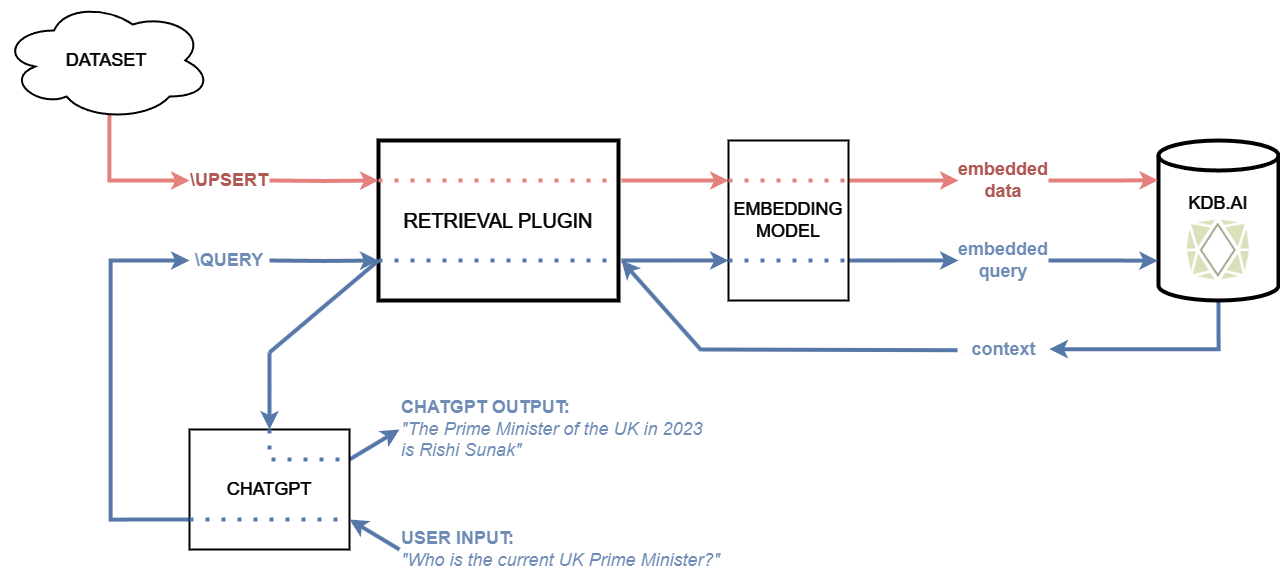

The diagram above provides a high-level overview of the system, and explains how ChatGPT, the Retrieval Plugin, and KDB.AI all interact with one another. The system can be broken down into two main sub-systems: upserting (shown in red) and querying (shown in blue).


### Upserting

Upserting is the process of taking our own dataset and uploading it to our vector database. In order to upsert data, we must pre-process it to remove any part we do not want to store in the database, change the format to a dictionary, and divide it into batches. When we call  `/upsert`, each batch of data is embedded using an OpenAI LLM (Large Language Model), to generate a vector embedding for similarity search. The data and its embedding are then inserted into a KDB.AI table.


### Querying

Querying involves taking an input query, or question, transforming it into an embedded vector, and running similarity search in the vector database to find its nearest neighbours - data with closest relevancy to the query. When we call `/query`,  the input query is embedded with the same OpenAI LLM used for upserting, to generate a query vector. A similarity search algorithm running within KDB.AI will return the N closest matches with highest relevancy to the query. This "context" is then sent back to ChatGPT via the Retrieval Plugin. Finally, using this contextual information, ChatGPT outputs a human-like response to the query.

Having an external source of data greatly increases the applicability of ChatGPT to different tasks. For example: GPT-3.5 can only answer questions with information it has seen during training, which is capped at 2021.. Therefore, if you asked it who the 2023 UK Prime Minister is, the model does not have the necessary information. However, if you were to download a dataset of political data up to the present day, ChatGPT would be able to use this data to answer the question. 

## Getting Started

### Prerequisites

- Python 3
- Pip
- Git

### Install the KDB.AI ChatGPT Retrieval Plugin server app

```
git clone https://github.com/KxSystems/chatgpt-retrieval-plugin -b KDB.AI
cd chatgpt-retrieval-plugin
pip install poetry
poetry install
```

### Run the KDB.AI ChatGPT Retrieval Plugin server app

```
export BEARER_TOKEN='<BEARER TOKEN>'  # you can create your own bearer token on auth0.com
export DATASTORE=kdbai
export KDBAI_ENDPOINT='<KDB.AI ENDPOINT>'
export KDBAI_API_KEY='<KDB.AI API KEY>'
export OPENAI_API_KEY='<OPENAI API KEY>'  # You can get a free API key on https://platform.openai.com

poetry run start
```

### Install a separate Jupyter environment to run this notebook

```
pip install datasets jupyter openai tqdm
```

### Run Jupyter

```
export BEARER_TOKEN='<BEARER TOKEN>'  # Same bearer token as above
export OPENAI_API_KEY='<OPENAI API KEY>'

jupyter notebook
```

Then open this notebook in Jupyter.

In [2]:
import os
from pprint import pprint
import random

from datasets import load_dataset
import openai
import requests
from tqdm.auto import tqdm

In [3]:
BEARER_TOKEN = os.environ.get("BEARER_TOKEN")

### Load Dataset from Hugging Face

The Adversarial_QA dataset is chosen for this demonstration. It consists of questions that current state-of-the-art models find challenging, paired with contextual data that can be used to formulate an answer. Some of these questions have very poor grammar ("What sare the benifts of the blood brain barrir?"), and others are purposefully vague ("What is at the highest level?"), as shown in the example below:

In [4]:
data = load_dataset("adversarial_qa", 'adversarialQA', split="train").to_pandas()
data = data.drop_duplicates(subset=["context"])
print(f"Number of unique contexts: {len(data)}")
data.head()

Number of unique contexts: 2648


,id,title,context,question,answers,metadata
0,7ba1e8f4261d3170fcf42e84a81dd749116fae95,Brain,Another approach to brain function is to exami...,What sare the benifts of the blood brain barrir?,"{'text': ['isolated from the bloodstream'], 'a...","{'split': 'train', 'model_in_the_loop': 'Combi..."
12,936a8460bfffe437b54cf3ec1e825a3b7b5627a1,Brain,Motor systems are areas of the brain that are ...,What do you think with?,"{'text': ['brain'], 'answer_start': [467]}","{'split': 'train', 'model_in_the_loop': 'Combi..."
24,e40737d487964dbcd26a223f2799cf56390a98a8,Brain,The brain is an organ that serves as the cente...,How are neurons connected?,"{'text': ['synapses'], 'answer_start': [602]}","{'split': 'train', 'model_in_the_loop': 'Combi..."
37,a0f8e785a10f6e21e24207d24ba2823162383062,Brain,The SCN projects to a set of areas in the hypo...,The body's central biological clock is contain...,"{'text': ['SCN'], 'answer_start': [4]}","{'split': 'train', 'model_in_the_loop': 'Combi..."
53,6d753d4a8878b5f5bc496d9a369b8c0b212079a0,Brain,The brain contains several motor areas that pr...,What is at the highest level?,"{'text': ['the primary motor cortex'], 'answer...","{'split': 'train', 'model_in_the_loop': 'Combi..."


To use this dataset for Q&A with ChatGPT, we need to insert the relevant data into our vector datastore - KDB.AI. The only column of data we will insert is the "context" column, which we reformat into a dictionary.

In [5]:
# extract text data from the dataset
documents = [
    {
        'text': r['context'],
    } for r in data.to_dict(orient='records')
]
pprint(documents[0])

{'text': 'Another approach to brain function is to examine the consequences of '
         'damage to specific brain areas. Even though it is protected by the '
         'skull and meninges, surrounded by cerebrospinal fluid, and isolated '
         'from the bloodstream by the blood–brain barrier, the delicate nature '
         'of the brain makes it vulnerable to numerous diseases and several '
         'types of damage. In humans, the effects of strokes and other types '
         'of brain damage have been a key source of information about brain '
         'function. Because there is no ability to experimentally control the '
         'nature of the damage, however, this information is often difficult '
         'to interpret. In animal studies, most commonly involving rats, it is '
         'possible to use electrodes or locally injected chemicals to produce '
         'precise patterns of damage and then examine the consequences for '
         'behavior.'}


### Insert data to the KDB.AI table

In [5]:
# initialise an HTTP session with the KDB.AI ChatGPT Retrieval Plugin app
s = requests.Session()

The `/upsert` instruction is used to insert data to the KDB.AI datastore in batches, with each batch being embedded with OpenAI Embedding Model `text-embedding-ada-002` before it is added to the table. We take our contextual data, which has been reformatted into a dictionary, and call `/upsert` on batches of 100 documents at a time. 

In [6]:
batchSize = 100

# upsert documents from the dataset in batches
for i in tqdm(range(0, len(documents), batchSize)):
    i_end = min(len(documents), i+batchSize)
    
    res = s.post(
        "http://localhost:8000/upsert",
        
        headers = {
            "Authorization": f"Bearer {BEARER_TOKEN}"
        },
        
        json = {
            "documents": documents[i:i_end]
        }
    )

  0%|          | 0/27 [00:00<?, ?it/s]

NameError: name 's' is not defined

### Query the KDB.AI table

We can take the list of questions from our dataset and format them into a dictionary. We will randomly choose 5 of these questions to be our queries in this example.

In [8]:
# extract questions and reformat into queries
queries = data['question'].tolist()
queries = [{'query': queries[i]} for i in range(len(queries))]

# choose 5 queries at random 
i = random.randint(0, len(queries)-5)
searchQueries = queries[i:i+5]

print(searchQueries)

[{'query': 'What is the third part of the death penalty process?'}, {'query': 'Name one of the Panglong Conference negotiators who had a professional title.'}, {'query': 'How did Myanmar increase their rating by 1?'}, {'query': 'How are nats paid tribute to in Bamar culture?'}, {'query': 'When did the military begin its transition?'}]


The `/query` instruction is used to extract relevant information from the KDB.AI datastore. The queries are embedded into vectors, and a similarity search algorithm is used to calculate its nearest neighbours, representing the most relevant entries in the table. 

In [8]:
# query the vector database
results = requests.post(
    "http://localhost:8000/query",
    
    headers = {
        "Authorization": f"Bearer {BEARER_TOKEN}"
    },
    
    json = {
        'queries': searchQueries
    }
)

print(results)

<Response [200]>


In the cell below, we iterate through each query and its results, and pass this data to ChatGPT, which uses it to respond to the query with natural language. Here, you can see the three "nearest neighbour" pieces of context that ChatGPT uses to form its answer.

In [9]:
# iterate through each set of queries/results
for query_response in results.json()['results']:
    query = query_response['query']
    answers = []
    scores = []
    
    # extract answers and scores from each result
    for result in query_response['results']:
        
        # answer = textual information related to the query
        answers.append(result['text'])
        
        # score = distance between the query vector and the answer vector (smaller=better!)
        scores.append(round(result['score'], 2))
    
    # print the query
    print("\nQUERY:\n"+query)
    
    # print the query responses, and their scores
    print("\nCONTEXT:\n"+"\n".join([f"{s}: {a}" for a, s in zip(answers, scores)])+"\n")
    
    # format the query and its answers into GPT messages
    messages = [
        {"role": "system", "content": f"You are a helpful assistant with the following knowledge: {answers}"},
        {"role": "user", "content": f"Using your knowledge, answer this query: {query}"}
    ]
    
    # send the messages to a GPT model
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=messages,
      max_tokens=100,
      n=1,
      stop=None,            
    )

    # extract the generated response from the API response
    generated_response =response['choices'][0]['message']['content']
    
    # Print the generated response
    print(f"RESPONSE: \n{generated_response}\n")
    print("-"*70)


QUERY:
When was the half dollar last issued by the government?

CONTEXT:
0.33: The Gold Standard Act of 1900 abandoned the bimetallic standard and defined the dollar as 23.22 grains (1.505 g) of gold, equivalent to setting the price of 1 troy ounce of gold at $20.67. Silver coins continued to be issued for circulation until 1964, when all silver was removed from dimes and quarters, and the half dollar was reduced to 40% silver. Silver half dollars were last issued for circulation in 1970. Gold coins were confiscated by Executive Order 6102 issued in 1933 by Franklin Roosevelt. The gold standard was changed to 13.71 grains (0.888 g), equivalent to setting the price of 1 troy ounce of gold at $35. This standard persisted until 1968.
0.34: Early releases of the Washington coin included error coins shipped primarily from the Philadelphia mint to Florida and Tennessee banks. Highly sought after by collectors, and trading for as much as $850 each within a week of discovery, the error coins 

### Delete the KDB.AI table

To delete the KDB.AI table, run the code cell below. Once this is done, the ChatGPT Retrieval Plugin app will need to be restarted to create another table.

In [10]:
## One would need to restart the KDB.AI ChatGPT Retrieval Plugin server app
## after this, to recreate the table
res = requests.delete(
    "http://localhost:8000/delete",
    headers = {
        "Authorization": f"Bearer {BEARER_TOKEN}"
    }, 
    json = {
        "delete_all": True
    }
)